# Introduction

In this problem you will be analysing time series data. Specifically, the data that you will be working with has been collecting via Pittsburgh's TrueTime system which is available publicly here http://truetime.portauthority.org/bustime/login.jsp. If you're interested, you can request an API key and collect the data yourself (the process is just submitting a form), however we've already collected some smaller subset of the available data for the purposes of this assignment. 

## Part 1 TrueTime dataset

The bus data has been collected by querying the TrueTime API every minute. Each time, we make two requests: 

1. We request vehicle information for every bus running on the 61A, 61B, 61C, and 61D bus routes. 
2. We request all available time predictions for the CMU / Morewood bus stop in both outbound and inbound directions. 

The results are given as XML, which are consequently parsed and stored within a sqlite database with two tables, one for vehicles and one for predictions. The table for the vehicles is organized in the following manner.  

| | **vehicles**             | 
|----------|-------------|
| vid      | vehicle identifier |
| tmstmp | date and time of the last positional update of the vehicle |
| lat | latitude position of the vehicle in decimal degrees |
| lon | longitude position of the vehicle in decimal degrees |
| hdg | heading of vehicle as a 360 degree value (0 is north, 90 is east, 180 is south, and 270 is west |
| pid | pattern ID of trip currently being executed | 
| rt | route that is currently being execute | 
| des | destination of the current trip | 
| pdist | linear distance (feet) vehicle has traveled into the current pattern |
|  spd | speed as reported from the vehicle in miles per hour | 
| tablockid | TA's version of the scheduled block identifier for work currently behind performed |
| tatripid | TA's version of the scheduled trip identifier for the vehicle's current trip |

The table for the predictions is organized in the following manner

| | **predictions** | 
|---|---|
| tmstmp | date and time the prediction was generated |
| typ | type of prediction (A for arrival, D for a departure) | 
| stpnm | display name of the stop for which this prediction was generated |
| stpid | unique identifier representing the stop for which this prediction was generated |
| vid | unique ID of the vehicle for which this prediction was generated |
| dstp | linear distance (feet) left to be traveled by the vehicle before it reaches the stop for which this prediction was generated |
| rt | route for which this prediction was generated | 
| rtdd | language-specific route designator meant for display |
| rtdir | direction of travel of the route associated with this prediction |
| des | final destination of the vehicle associated with this prediction |
| prdtm | predicted date and time of a vehicle's arrival or departure to the stop associated with this prediction | 
| dly | true if the vehicle is delayed, only present if the vehicle that generated this prediction is delayed | 
| tablockid | TA's version of the scheduled block identifier for work currently behind performed |
| tatripid | TA's version of the scheduled trip identifier for the vehicle's current trip |
    

First you will need to read in the data. We have dumped the raw form of the data into a sqlite database, which you can read directly into a pandas dataframe. 

Since this data has not been processed at all by the course staff, you will need to fix and canonicalize a few things. 

### Specification

1. Sometimes the TrueTime API returns a bogus result that has all the attributes but empty strings for all the values. You should inspect the data for clearly useless entries and remove all offending rows. 

2. If you check the datatype of each column, you'll notice that most columns are stored as objects. However, some of these columns are in fact integers or floats, and if you wish to run numerical functions on them (like with numpy) you'll need to convert the columns to the correct type. Note that strings show up as objects. This is because the underlying implementation of Pandas uses numpy arrays, which need fixed-size entries, so they store pointers to strings. Your dataframe datatypes should match the following order and types (your datatypes may be 32bit instead of 64bit depending on your platform): 

   ```python
   >>> vdf.dtypes
   vid                   int64
   tmstmp       datetime64[ns]
   lat                 float64
   lon                 float64
   hdg                   int64
   pid                   int64
   rt                   object
   des                  object
   pdist                 int64
   spd                   int64
   tablockid            object
   tatripid              int64
   dtype: object

   >>> pdf.dtypes
   tmstmp       datetime64[ns]
   typ                  object
   stpnm                object
   stpid                 int64
   vid                   int64
   dstp                  int64
   rt                   object
   rtdd                 object
   rtdir                object
   des                  object
   prdtm        datetime64[ns]
   dly                    bool
   tablockid            object
   tatripid              int64
   dtype: object
   ```

3. As you may have noticed from the above data types, you should convert all timestamps to Pandas datetime objects. 

In [3]:
import pandas as pd
import sqlite3
import datetime
import numpy as np

In [2]:
def load_data(fname):
    """ Read the given database into two pandas dataframes. 
    
    Args: 
        fname (string): filename of sqlite3 database to read
        
    Returns:
        (pd.DataFrame, pd.DataFrame): a tuple of two dataframes, the first for the vehicle data and the 
                                      second for the prediction data. 
    """
    conn=sqlite3.connect(fname)
    cursor = conn.cursor()
    vdf = pd.read_sql_query("SELECT * FROM vehicles", conn)
    pdf = pd.read_sql_query("SELECT * FROM predictions", conn)
    #vdf.astype({'vid':'int64'},errors='ignore')
    #vdf=vdf.replace(r'\s+', np.nan, regex=True)
    #pdf=pdf.replace(r'\s+', np.nan, regex=True)
    vdf['lat']=pd.to_numeric(vdf['lat'], errors='ignore', downcast=None)
    vdf['lon']=pd.to_numeric(vdf['lon'], errors='ignore', downcast=None)
    pdf['tmstmp']=pd.to_datetime(pdf['tmstmp'])
    pdf['prdtm']=pd.to_datetime(pdf['prdtm'])
    #vdf['vid'].fillna(0).astype('int64')
    
    vdf=vdf.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
    pdf=pdf.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
    
    vdf['hdg'] = vdf['hdg'].astype(str).astype(np.int64)
    vdf['vid'] = vdf['vid'].astype(str).astype(np.int64)
    vdf['pid'] = vdf['pid'].astype(str).astype(np.int64)
    vdf['pdist'] = vdf['pdist'].astype(str).astype(np.int64)
    vdf['spd'] = vdf['spd'].astype(str).astype(np.int64)
    vdf['tatripid'] = vdf['tatripid'].astype(str).astype(np.int64)
    pdf['stpid'] = pdf['stpid'].astype(str).astype(np.int64)
    pdf['vid'] = pdf['vid'].astype(str).astype(np.int64)
    pdf['dstp'] = pdf['dstp'].astype(str).astype(float).astype(np.int64)
    pdf['tatripid'] = pdf['tatripid'].astype(str).astype(np.int64)
    vdf['tmstmp']=pd.to_datetime(vdf['tmstmp'])
    pdf['dly']=pdf['dly'].astype(bool)
    #vdf['vid']=pd.to_int64(vdf['vid'])
    #a=cursor.fetchall
    return (vdf,pdf)
#     for row in cursor.execute("SELECT * FROM fname;"):
#         print(row)
#     vdf=pd.DataFrame.from_records(conn, index=None, exclude=None, columns=None, coerce_float=False, nrows=None)
#     pdf=pd.DataFrame.from_records(conn, index=None, exclude=None, columns=None, coerce_float=False, nrows=None)
#     pass
    


In [3]:
# AUTOLAB_IGNORE_START
vdf, pdf = load_data('bus_aug23.db')


# Inspect the datatypes of the dataframe
print (vdf.dtypes)
print (pdf.dtypes)

print (len(vdf), len(pdf))

# Inspect the first five entries of the dataframe
print (vdf)
print (pdf.head())
# AUTOLAB_IGNORE_STOP

vid                   int64
tmstmp       datetime64[ns]
lat                 float64
lon                 float64
hdg                   int64
pid                   int64
rt                   object
des                  object
pdist                 int64
spd                   int64
tablockid            object
tatripid              int64
dtype: object
tmstmp       datetime64[ns]
typ                  object
stpnm                object
stpid                 int64
vid                   int64
dstp                  int64
rt                   object
rtdd                 object
rtdir                object
des                  object
prdtm        datetime64[ns]
dly                    bool
tablockid            object
tatripid              int64
dtype: object
215473 143345
         vid              tmstmp        lat        lon  hdg   pid   rt  \
0       5549 2016-08-11 10:56:00  40.439504 -79.996981  114  4521  61A   
1       5287 2016-08-11 10:56:00  40.438016 -79.927380   83  4521  61A   
2       

## Part 2 Splitting Trips

For this assignment, we will focus on the vehicles dataframe and come back to the predictions later. The next thing we will do is take the dataframe of vehicles and and split it into individual trips. Specifically, a trip is the sequence of rows corresponding to a single bus, typically at one minute intervals, from the start of its route to the end of its route. We will represent each trip as an individual dataframe, and create a list of trip dataframes to represent all the trips.

### Specification
1. All entries in a trip should belong to a single route, destination, pattern, and vehicle.

2. The entries in a trip should have (not strictly) monotonically increasing timestamps and distance traveled. 

3. Each trip should be of maximal size. I.e. you should sort first by time, and secondarily by pdist, and use a drop in a pdist as an indication that a new trip has started. 

3. Each trip should have the timestamp set as the index, named `tmstmp`

In [4]:
vdf1=vdf.sort_values(['rt','des','pid','vid','tmstmp'], axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
vdf1=vdf1.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
vdf1.drop(labels='index', axis=1, inplace=True, errors='raise')
#vdf1=vdf1.set_index('tmstmp', drop=True, append=False, inplace=False, verify_integrity=False)

#vdf1.sort_values([], axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
vdf1

,vid,tmstmp,lat,lon,hdg,pid,rt,des,pdist,spd,tablockid,tatripid
0,3202,2016-08-11 15:02:00,40.415163,-79.879468,48,4663,61A,Downtown,281,0,061A-178,6466
1,3202,2016-08-11 15:03:00,40.415882,-79.879486,48,4663,61A,Downtown,495,0,061A-178,6466
2,3202,2016-08-11 15:04:00,40.415882,-79.879486,48,4663,61A,Downtown,495,0,061A-178,6466
3,3202,2016-08-11 15:05:00,40.415882,-79.879486,48,4663,61A,Downtown,495,0,061A-178,6466
4,3202,2016-08-11 15:06:00,40.415882,-79.879486,48,4663,61A,Downtown,495,0,061A-178,6466
5,3202,2016-08-11 15:07:00,40.415882,-79.879486,48,4663,61A,Downtown,495,0,061A-178,6466
6,3202,2016-08-11 15:09:00,40.416004,-79.879395,35,4663,61A,Downtown,549,8,061A-178,6466
7,3202,2016-08-11 15:10:00,40.418530,-79.883293,307,4663,61A,Downtown,2075,23,061A-178,6466
8,3202,2016-08-11 15:11:00,40.420330,-79.884888,290,4663,61A,Downtown,3022,8,061A-178,6466
9,3202,2016-08-11 15:12:00,40.422298,-79.886011,59,4663,61A,Downtown,4020,1,061A-178,6466


In [5]:
len(vdf)==len(vdf1)

True

In [6]:
a=[]
i=1
e=0

for j in range (1,len(vdf1)):
    if ((vdf1.iloc[j-1,8]>vdf1.iloc[j,8])or(vdf1.iloc[j-1,0]!=vdf1.iloc[j,0])):
        e=j
        vdf2=(vdf1.iloc[i-1:e,:])
        vdf2=vdf2.set_index('tmstmp', drop=True, append=False, inplace=False, verify_integrity=False)
        a.append(vdf2)
        e=e+1
        i=e

vdf1=vdf1.set_index('tmstmp', drop=True, append=False, inplace=False, verify_integrity=False) 
a.append(vdf1.iloc[e-1:,:])

In [7]:
len(a)

4618

In [8]:
len(vdf1)

215473

You should verify that your code meets the specification above. Use this cell to write tests that check the validity of your resulting output. For example,you should test that the total number of datapoints in the list of dataframes is the same as the number of datapoints in the original dataframe. 

In [9]:
# Test the validity of your code here



## Part 3 Sliding Averages

Let's compute a basic statistic for time series / sequential data, which is the sliding average. Sliding averages are typically used to smooth out short-term fluctuations to see the long-term patterns. 

While it would be fairly simple to directly construct a list of all the sliding averages from the existing dataset, in reality, new TrueTime bus data is constantly becoming available. We want to avoid recomputing all the sliding averages every time a new data point comes in. Thus, instead of storing an unbounded list of datapoints, we will construct a class which does constant time updates as new data comes in. 

### Specifications
1. Your function should not use more than O(k) memory, where k is the number of elements to average. 
2. Each update should do O(1) work. 
3. We will use a centered sliding average: we will average the k values both before and after the center point, averaging a total of 2k+1 elements. Note that k=0 will just return the stream without any averaging. 
4. Since the average depends on both past and future elements, the `update` function will not be able to output anything useful for the first k elements. You should output `None` during these iterations. We suggest you signify the end of the stream by calling `update(None)` k times, during which you should output the last k sliding averages. 
4. When at the beginning or end of a list, just compute the average of elements that exist. 
5. As usual, you should test the correctness of your code. You can do this in the same cell or make a new cell.

Note: you may find the `collections.deque` data structure to be helpful. 

Example: 
```python
>>> compute_sliding_averages(pd.Series([1,2,3,4,5]),1)
pdf.Series([1.5, 2.0, 3.0, 4.0, 4.5])
```

In [10]:
from collections import deque
s=pd.Series([1,2,3,4,5])
k=1

def sliding(s,k):

    SA = pd.Series()
    q=deque([], maxlen=2*k+1)

    # if len(SA)==0:
    sum_sa=0  


    for num in s[0:k]:
        q.append(num)
        sum_sa=sum_sa+num
    #     SA.set_value(len(SA), None, takeable=False)


    for num in s[k:2*k+1]:
        q.append(num)
        sum_sa=sum_sa+num
        avg=sum_sa/len(q)
        SA.set_value(len(SA), avg, takeable=False)

    for num in s[2*k+1:]:
        sum_sa=sum_sa-q[0]
        q.popleft()
        q.append(num)
        sum_sa=sum_sa+num
        avg=sum_sa/(2*k+1)
        SA.set_value(len(SA), avg, takeable=False)

    for num in s[-2*k-1:-k-1]:
        sum_sa=sum_sa-q[0]
        q.popleft()
        avg=sum_sa/len(q)
        SA.set_value(len(SA), avg, takeable=False)
    
    return SA
    
# if len(q)==2*k+1:
#     for nums in q:
#             sum_sa=sum_sa+nums
#             avg=sum_sa/(2*k+1)
            
#         SA.popleft()
#         SA.set_value(len(SA), num, takeable=False)


In [2]:
from collections import deque

class SlidingAverage:
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.k=k
        self.q=deque([], maxlen=2*self.k+1)
        self.sum_sa=0
        self.l=0
        
       
        
        
    def update(self,x):
        """ Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        
        self.x=x
        
        if len(self.q)<self.k and self.x!=None:
            self.q.append(self.x)
            self.sum_sa=self.sum_sa+self.x
            return None
        
        elif len(self.q)<2*self.k+1 and self.x!=None:
            self.q.append(self.x)
            self.sum_sa=self.sum_sa+self.x
            self.avg=self.sum_sa/len(self.q)
            return self.avg
        
        elif len(self.q)==2*self.k+1 and self.x!=None:
            self.w=self.q.popleft()
            self.q.append(self.x)
            self.sum_sa=self.sum_sa-self.w+self.x
            self.avg2=self.sum_sa/len(self.q)
            return self.avg2
        
        elif len(self.q)<=2*self.k+1 and self.x==None:
            self.l=self.l+1
            self.w2=self.q.popleft()
            self.q.append(self.x)
            self.sum_sa=self.sum_sa-self.w2
            self.avg3=self.sum_sa/(len(self.q)-self.l)
            return self.avg3
        
#         elif len(self.q)<=self.k and self.x==None:
#             #q.popleft()
#             return None
    

    #SA = SlidingAverage(10)

# def compute_sliding_averages(s, k):
#     """ Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
#     Args:
#         s (pd.Series): a Pandas series for which the sliding average needs to be calculated
#         k (int): the half-width of the sliding average window 
        
#     Returns:
#         (pd.Series): a Pandas series of the sliding averages
    
#     """
#     SA = pd.Series()
#     sa=SlidingAverage(k)
#     j=0
#     for num in s:
#         #q.append(num)
#         m=sa.update(num)
        
#         if m!=None:
#             SA.set_value(j, m, takeable=False)
#             j=j+1
    
#     for i in range(k):
#         m2=sa.update(None)
        
#         if m2!=None:
#             SA.set_value(j, m2, takeable=False)
#             j=j+1
    
#     return SA
        
    

# # Test your code!


In [38]:
from collections import deque

class SlidingAverage:
    
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.k=k
        self.q=deque([], maxlen=2*self.k+1)
        self.sum_sa=0
        self.l=0
        self.c=0             
        
    def update(self,x):
        """ Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        
        self.x=x
        
        if self.c<self.k and self.x!=None:
            self.q.append(self.x)
            self.c=self.c+1
            self.sum_sa=self.sum_sa+self.x
            return None
        
        elif self.c<2*self.k+1 and self.x!=None:
            self.q.append(self.x)
            self.c=self.c+1
            self.sum_sa=self.sum_sa+self.x
            self.avg=self.sum_sa/self.c
            return self.avg
        
        elif self.c==2*self.k+1 and self.x!=None:
            self.w=self.q.popleft()
            self.q.append(self.x)
            self.sum_sa=self.sum_sa-self.w+self.x
            self.avg2=self.sum_sa/self.c
            return self.avg2
        
        elif self.c<=2*self.k+1 and self.c>self.k and self.x==None:
            self.l=self.l+1
            self.w2=self.q.popleft()
            self.q.append(self.x)
            self.sum_sa=self.sum_sa-self.w2
            self.avg3=self.sum_sa/(self.c-self.l)
            return self.avg3
        
        elif self.c<=self.k and self.x==None:
            #self.q.append(self.x)
            self.avg4=self.sum_sa/(self.c-self.l)
            #self.q.pop()
            return self.avg4
                
#         elif len(self.q)<=self.k and self.x==None:
#             #q.popleft()
#             return None
    

    #SA = SlidingAverage(10)

def compute_sliding_averages(s, k):
    """ Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window 
        
    Returns:
        (pd.Series): a Pandas series of the sliding averages
    
    """
    SA = pd.Series()
    sa=SlidingAverage(k)
    j=0
    for num in s:
        #q.append(num)
        m=sa.update(num)
        if m!=None:
            SA.set_value(j, m, takeable=False)
            j=j+1
            
    if len(s)>k: 
        for i in range(k):
                m2=sa.update(None)
                if m2!=None:
                    SA.set_value(j, m2, takeable=False)
                    j=j+1
    
    if len(s)<=k:
        for i in range(len(s)):
            m3=sa.update(None)
            if m3!=None:
                SA.set_value(j, m3, takeable=False)
                j=j+1

    return SA
        
    

# Test your code!

#SA=pd.Series(sa.update(num)) for num in s if sa.update(num)!=None

In [105]:
from collections import deque

class SlidingAverage:
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.k=k
        self.q=deque([], maxlen=2*self.k+1)
        self.sum_sa=0
        self.l=0
        self.c=0             
        
    def update(self,x):
        """ Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        
        self.x=x
        
        if len(self.q)<self.k and self.x!=None:
            self.q.append(self.x)
            #self.c=self.c+1
            self.sum_sa=self.sum_sa+self.x
            
        
            #return None
        
        elif len(self.q)<2*self.k+1 and self.x!=None:
            self.q.append(self.x)
            #self.c=self.c+1
            self.sum_sa=self.sum_sa+self.x
            self.avg=self.sum_sa/len(self.q)
            return self.avg
        
        elif len(self.q)==2*self.k+1 and self.x!=None:
            self.w=self.q.popleft()
            self.q.append(self.x)
            self.sum_sa=self.sum_sa-self.w+self.x
            self.avg2=self.sum_sa/len(self.q)
            return self.avg2
        
        elif len(self.q)<=2*self.k+1 and len(self.q)>self.k+1 and self.x==None:
            self.l=self.l+1
            #self.w2=self.q.popleft()
            self.q.append(self.x)
            #self.sum_sa=self.sum_sa-self.w2
            self.avg3=self.sum_sa/(len(self.q)-self.l)
            return self.avg3
        
        elif len(self.q)<=self.k+1 and self.x==None:
            #self.l=self.l+1
            self.w3=self.q.popleft()
            self.sum_sa=self.sum_sa-self.w2
            self.avg3=self.sum_sa/(len(self.q))
        
        elif len(self.q)<=self.k and self.x==None:
            #self.q.append(self.x)
            self.avg4=self.sum_sa/(len(self.q))
            #self.q.pop()
            return self.avg4
                
#         elif len(self.q)<=self.k and self.x==None:
#             #q.popleft()
#             return None
    

    #SA = SlidingAverage(10)

def compute_sliding_averages(s, k):
    """ Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window 
        
    Returns:
        (pd.Series): a Pandas series of the sliding averages
    
    """
    l = []
    sa=SlidingAverage(k)
    #s=s.dropna()
    #j=0
    for num in s:
        
        m=sa.update(num)
        if m!=None:
                l.append(m)
            #j=j+1
            
    if len(s)>k: 
        for i in range(k):
                m2=sa.update(None)
                if m2!=None:
                    l.append(m2)
                    #j=j+1
    
    if len(s)<=k:
        for i in range(len(s)):
            m3=sa.update(None)
            if m3!=None:
                l.append(m3)
                #j=j+1
    
    SA =pd.Series(l)

    return SA
        
    

# Test your code!
#[(sa.update(num)) for num in s if sa.update(num)!=N]
#SA=pd.Series(sa.update(num)) for num in s if sa.update(num)!=None

In [490]:
SA2=pd.Series()
for num in s:
    SA=pd.Series(num)
    SA2=SA2.append(SA,ignore_index=True)
SA2

0    1
1    2
2    3
3    4
4    5
dtype: int64

In [106]:
s=pd.Series([1,2,3,4,5])
k=1
#s=s.dropna()



compute_sliding_averages(s, k)


0    1.5
1    2.0
2    3.0
3    4.0
4    6.0
dtype: float64

[(x, y) for x in [1,2,3] for y in [3,1,4] if x != y]

combs = []
>>> for x in [1,2,3]:
...     for y in [3,1,4]:
...         if x != y:
...             combs.append((x, y))

## Part 4 Time Series Visualizations

Time series data is typically displayed as signals over time. For example, this could be the speed of the bus over time, or the number of minutes behind or ahead of schedule a bus is. 

In [14]:
import matplotlib
# Use svg backend for better quality
# AUTOLAB_IGNORE_START
matplotlib.use("svg")
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
# AUTOLAB_IGNORE_START
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen
# AUTOLAB_IGNORE_STOP

As the first example, you'll plot the speed of the bus as a function of time. Here, we'll overlay multiple routes on a single plot. Can you determine the direction of the bus (to or away from downtown) from the signal? 

### Specification:
1. Plot the sliding average speed of each bus, using a new line for each bus. 
2. Return a list of the resulting `Line2D` objects plot. The order of the line objects should correspond with the order of the trips. 
3. Do not call `plt.show()` inside the function. Autolab will not X out of any plotted images. 
4. We want you to plot the bus as a function of time, and not of datetime (these are different python types) which is the index of your dataframe. You can get the time with df.index.time. 

In [180]:
# for i in range(len(a)):
#     a[i].index=a[i].index.time
#a[1]
# b=[]
for i in range(len(a)):
    c=compute_sliding_averages(a[i]['spd'],1)
    a[i]['avgs']=c.values
    d=a[i]['avgs'].plot(kind='line', ax=None, use_index=True) 
    b.append(d)

#plt.plot(compute_sliding_averages(a[0].spd,1))

4618

In [16]:
a[0].index

DatetimeIndex(['2016-08-11 15:02:00', '2016-08-11 15:03:00',
               '2016-08-11 15:04:00', '2016-08-11 15:05:00',
               '2016-08-11 15:06:00', '2016-08-11 15:07:00',
               '2016-08-11 15:09:00', '2016-08-11 15:10:00',
               '2016-08-11 15:11:00', '2016-08-11 15:12:00'],
              dtype='datetime64[ns]', name='tmstmp', freq=None)

In [17]:
def split_trips(df):
    """ Splits the dataframe of vehicle data into a list of dataframes for each individual trip. 
    
    Args: 
        df (pd.DataFrame): A dataframe containing vehicle data
        
    Returns: 
        (list): A list of dataframes, where each dataFrame contains vehicle data for a single trip
    """
    df1=df.sort_values(['rt','des','pid','vid','tmstmp'], axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
    df1=df1.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
    df1.drop(labels='index', axis=1, inplace=True, errors='raise')
    
    a=[]
    i=1
    e=0

    for j in range (1,len(df1)):
        if ((df1.iloc[j-1,8]>df1.iloc[j,8])or(df1.iloc[j-1,0]!=df1.iloc[j,0])):
            e=j
            df2=(df1.iloc[i-1:e,:])
            df2=df2.set_index('tmstmp', drop=True, append=False, inplace=False, verify_integrity=False)
            a.append(df2)
            e=e+1
            i=e
    df1=df1.set_index('tmstmp', drop=True, append=False, inplace=False, verify_integrity=False)
    a.append(df1.iloc[i-1:,:])
    
    return a

C:\Users\gandh\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\gandh\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\gandh\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


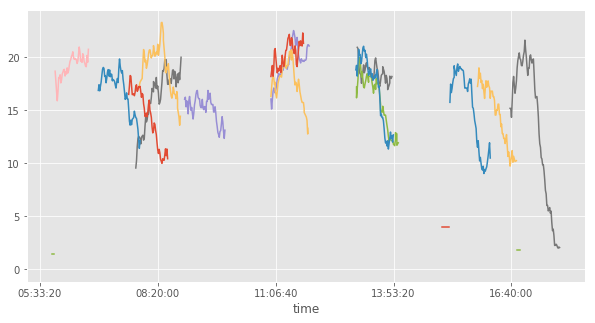

In [20]:
def plot_trip(trips, k):
    """ Plots the sliding average speed as a function of time 
    
    Args: 
        trip (list): list of trip DataFrames to plot
        k (int): the half-width of the sliding average window
    """
    b=[]
    for i in range(len(trips)):
        trips[i].index=trips[i].index.time
        c=compute_sliding_averages(trips[i]['spd'],k)
        trips[i]['avgs']=c.values
        d=trips[i]['avgs'].plot(kind='line', ax=None, use_index=True) 
        b.append(d)
    return b 

    

# Play around with these values. Can you differentiate the buses going towards downtown from the buses going away from downtown?
# AUTOLAB_IGNORE_START
all_trips = { rt : split_trips(vdf[vdf["rt"]==rt]) for rt in ["61A", "61B", "61C", "61D"] }
lines = plot_trip(all_trips['61A'][:20], 15)
#plt.show()
# AUTOLAB_IGNORE_STOP

We can also gain information from overall trends from averaging many data points. In the following function, you will plot the average speed of all buses at regular time intervals throughout the day. 

### Specification
1. You should group the rows of the dataframe by taking the timestamp modulo t and ignoring the day/month/year (since the data was collected at 1 minute intervals, this means that t=1 corresponds to averaging one entry per day recorded).
2. Return the PathCollection object of your plot. For example, if you create the plot using the matplotlib command `scatter(...)`, return the result of this function call. 
3. Do not call `plt.show()` inside the function. Autolab will not X out of any plotted images. 

In [ ]:
import datetime

def plot_avg_spd(df, t):
    """ Plot the average speed of all recorded buses within t minute intervals 
    Args: 
        df (pd.DataFrame): dataframe of bus data
        t (int): the granularity of each time period (in minutes) for which an average is speed is calculated
    """
    pass

# AUTOLAB_IGNORE_START
s = plot_avg_spd(vdf, 10)
plt.show()
# AUTOLAB_IGNORE_STOP

In [390]:
SA=pd.Series()
SA
len(SA)

0